In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display
from sklearn.linear_model import LinearRegression

# Datos

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


# Optimización

## Sharpe

In [3]:
def opt_sharpe(rt, rf):
    mu = rt.mean().values * 252  
    cov = rt.cov().values 
    n = len(rt.keys())

    def sharpe(w, mu, cov, rf):
        mu_port = np.dot(mu, w)
        sigma_port = np.sqrt(np.dot(w.T, np.dot(cov * 252, w)))
        return -(mu_port - rf) / sigma_port  

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(sharpe, 
                      w0,
                      args=(mu, cov, rf),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_sharpe = result.x
    return w_sharpe

## LVRR

In [4]:
def opt_lvrr(price, volume, rt, rf, pv):
    mu = rt.mean().values * 252  
    cov = rt.cov().values 
    n = len(rt.keys())

    adv = volume.loc[volume.index >= volume.index.max() - pd.DateOffset(months=3)].mean()

    def lvrr(w, mu, cov, rf, pv, adv):
        mu_port = np.dot(mu, w)
        sigma_port = np.sqrt(np.dot(w.T, np.dot(cov * 252, w)))
        sharpe = (mu_port - rf) / sigma_port

        Ndays = (pv * w / price.iloc[-1])/adv
        return -(sharpe / np.sum(Ndays))

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(lvrr, 
                      w0,
                      args=(mu, cov, rf, pv, adv),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_lvrr = result.x
    return w_lvrr

## Semivarianza

In [5]:
def opt_semivar(rt, rt_benchmark):  
    diff = rt - rt_benchmark.values
    ds = np.array([np.std(np.where(diff[i] < 0, diff[i], 0)) for i in diff.keys()])
    corr = rt.corr().values 
    n = len(rt.keys())

    def semivar(w, ds, corr):
        semivar_mtx = np.dot(ds.T, ds) * corr
        return np.dot(w.T, np.dot(semivar_mtx, w))

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(semivar, 
                      w0,
                      args=(ds, corr),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_semivar = result.x
    return w_semivar

## Omega

In [6]:
def opt_omega(rt, rt_benchmark):  
    diff = rt - rt_benchmark.values
    ds = np.array([np.std(np.where(diff[i] < 0, diff[i], 0)) for i in diff.keys()])
    us = np.array([np.std(np.where(diff[i] > 0, diff[i], 0)) for i in diff.keys()])
    n = len(rt.keys())

    def omega(w, ds, us):
        omegas = us/ds
        return -np.dot(omegas, w.T)

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(omega, 
                      w0,
                      args=(ds, us),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_omega = result.x
    return w_omega

## Resultados

In [7]:
rf = 0.05
pv = 1000000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()

rt_benchmark_train = benchmark_train.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Sharpe

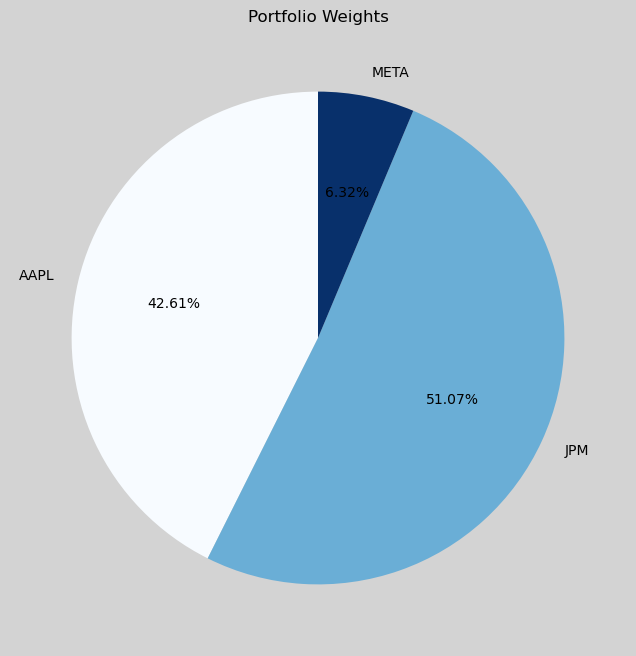

In [8]:
vt.plot_weights(tickers, opt_sharpe(rt_train, rf))

### LVRR

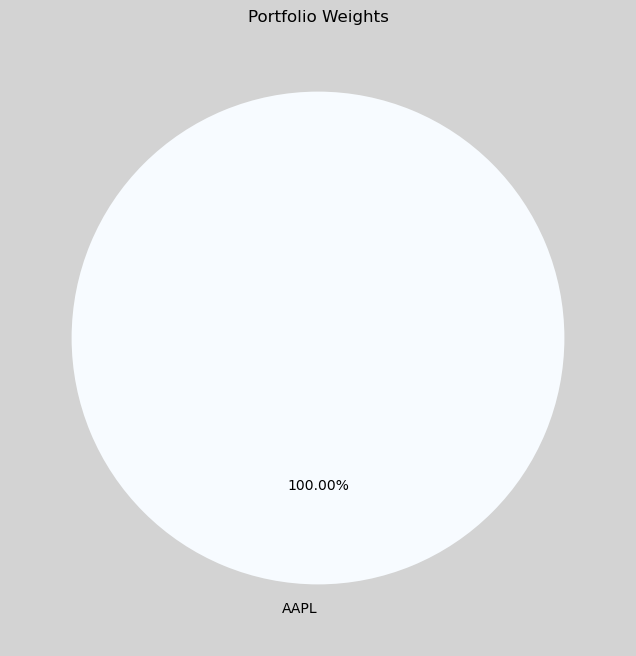

In [9]:
vt.plot_weights(tickers, opt_lvrr(price_train, volume_train, rt_train, rf, pv))

### Semivarianza

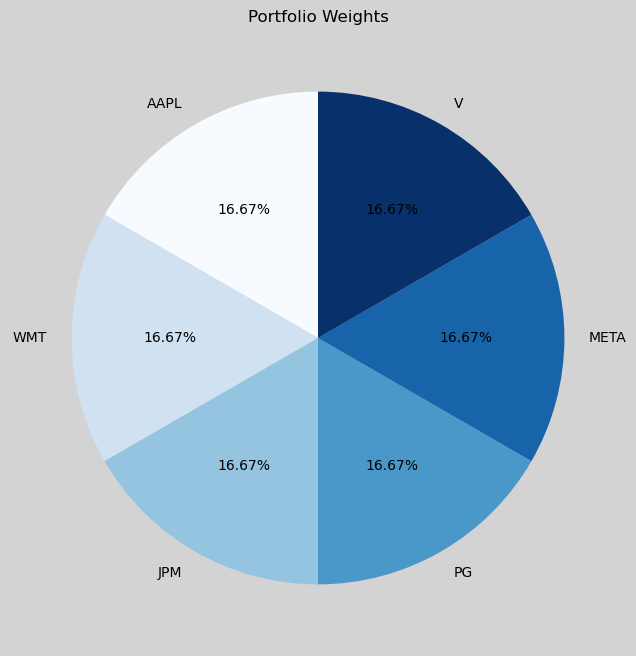

In [10]:
vt.plot_weights(tickers, opt_semivar(rt_train, rt_benchmark_train))

### Omega

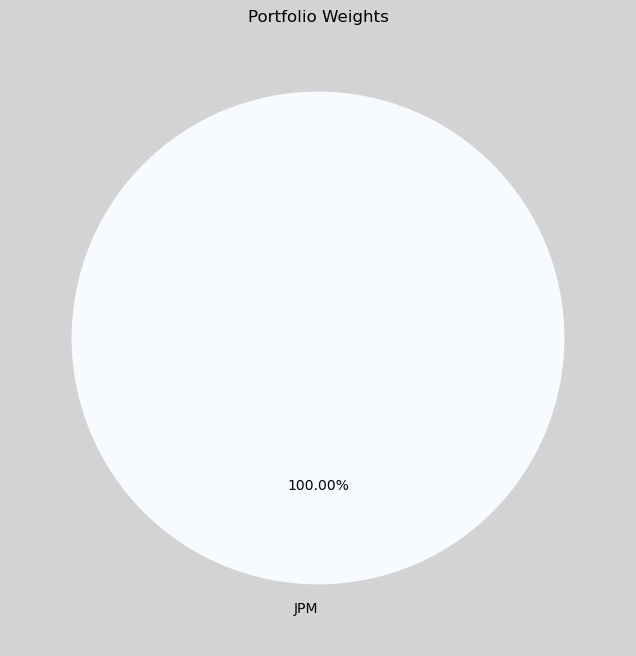

In [11]:
vt.plot_weights(tickers, opt_omega(rt_train, rt_benchmark_train))

# Múltiplos

In [12]:
def multiplos(ticker, start):
    def get_historical_price(ticker: str, start: str):
        end = start+datetime.timedelta(days=4)
        price=pd.DataFrame(yf.Ticker(ticker).history(start=start, end=end)["Close"])
        return price.iloc[0, 0]

    def get_financials(ticker:str) -> pd.DataFrame:
        bs = (yf.Ticker(ticker).balance_sheet.iloc[:, :-1] if '2020' in yf.Ticker(ticker).balance_sheet.keys().year.astype(str)
              else yf.Ticker(ticker).balance_sheet)
        ist = (yf.Ticker(ticker).income_stmt.iloc[:, :-1] if '2020' in yf.Ticker(ticker).income_stmt.keys().year.astype(str)
               else yf.Ticker(ticker).income_stmt)
        cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]
        return bs, ist, cf

    bs, ist, cf = get_financials(ticker)

    # EPS
    net_income = ist.loc['Net Income Common Stockholders']
    n_shares = bs.loc['Common Stock Equity']
    eps = (net_income/n_shares)

    # PER
    prices = [get_historical_price(ticker, date) for date in bs.columns]
    per = (prices/eps)

    # EBITDA
    ebitda = ((ist.loc['EBITDA']).values if 'EBITDA' in ist.index 
              else (np.nan))

    # PVB
    market_cap = n_shares*prices
    book_value = bs.loc['Total Capitalization']
    pvb = (market_cap/book_value)

    # Liquidity
    c_assets = (bs.loc["Current Assets"] if "Current Assets" in bs.index
                else (np.nan))
    c_liabilities = (bs.loc['Current Liabilities'] if 'Current Liabilities' in bs.index
                    else (np.nan))
    current_ratio = ((c_assets/c_liabilities).values if c_assets is not np.nan
                    else (np.nan))

    cash = (bs.loc['Cash Cash Equivalents And Short Term Investments'] if 'Cash Cash Equivalents And Short Term Investments' in bs.index
            else (np.nan))
    cash_ratio = ((cash/c_liabilities).values if cash is not np.nan
                 else (np.nan))

    # Solvency
    assets = bs.loc['Total Assets']
    liabilities = bs.loc['Total Liabilities Net Minority Interest']
    solvency = (assets/liabilities).values

    debt = bs.loc['Total Debt']
    equity = bs.loc['Total Capitalization']
    debt_equity = (debt/equity).values

    # ROE
    roe = (net_income/equity * 100)

    # Visualización
    años = pd.Series(roe.index.values).dt.year

    multiplos_df = pd.DataFrame({
        'EPS': eps.values,
        'PER': per.values,
        'EBITDA': ebitda,
        'PVB': pvb.values,
        'Current Ratio': current_ratio,
        'Cash Ratio': cash_ratio,
        'Solvency': solvency,
        'Debt/Equity': debt_equity,
        'ROE': roe.values
    }, index=años)

    return multiplos_df

## Resultados

In [13]:
for ticker in tickers:
     print(ticker)
     display(multiplos(ticker, start_date))
     print("===============================================================================================================")
     print()

AAPL


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,1.6459,141.2500,"134,661,000,000.0000",92.7835,0.8673,0.3695,1.1849,0.7472,65.6875
2023,1.5608,110.5140,"125,820,000,000.0000",68.0906,0.9880,0.4236,1.2140,0.7056,61.6127
2022,1.9696,69.2456,"130,541,000,000.0000",46.1864,0.8794,0.3137,1.1677,0.8854,66.6994
2021,1.5007,92.5319,"123,136,000,000.0000",50.8776,1.0746,0.4992,1.2191,0.7928,54.9839



WMT


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,0.1850,294.2834,"36,384,000,000.0000",38.0408,0.8319,0.1068,1.5597,0.5110,12.9266
2023,0.1523,306.4878,"30,089,000,000.0000",32.1512,0.8206,0.0935,1.5276,0.5292,10.4902
2022,0.1642,271.9134,"31,348,000,000.0000",31.4762,0.9278,0.1689,1.6007,0.4853,11.5758
2021,0.1669,262.2945,"34,031,000,000.0000",29.0176,0.9722,0.1915,1.5306,0.5179,11.0630



JPM


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,0.1751,"1,361.6766",NaN,105.4131,NaN,NaN,1.0942,0.6185,7.7414
2023,0.1589,"1,051.9304",NaN,69.8068,NaN,NaN,1.0924,0.6066,6.6361
2022,0.1355,941.0385,NaN,57.4225,NaN,NaN,1.0867,0.5779,6.1020
2021,0.1793,807.5754,NaN,63.1031,NaN,NaN,1.0853,0.5958,7.8139



PG


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,0.2949,541.9340,"22,582,000,000.0000",104.6857,0.7348,0.2820,1.7040,0.4417,19.3171
2023,0.3127,464.7230,"21,823,000,000.0000",93.8590,0.6334,0.2306,1.6380,0.4978,20.1968
2022,0.3161,424.4188,"21,241,000,000.0000",88.3898,0.6545,0.2181,1.6660,0.4651,20.8261
2021,0.3084,398.7676,"20,852,000,000.0000",80.5548,0.6969,0.3105,1.6421,0.4726,20.2009



META


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,0.3414,"1,714.8138","86,876,000,000.0000",505.6950,2.9779,2.3162,2.9551,0.2320,29.4898
2023,0.2553,"1,351.4428","59,052,000,000.0000",308.0023,2.6710,2.0464,3.0034,0.2170,22.7906
2022,0.1845,673.3520,"37,690,000,000.0000",115.1742,2.2034,1.5074,3.0947,0.1960,17.1046
2021,0.3153,"1,062.8198","55,274,000,000.0000",335.0701,3.1543,2.2710,4.0378,0.1111,31.5265



V


,EPS,PER,EBITDA,PVB,Current Ratio,Cash Ratio,Solvency,Debt/Equity,ROE
2024,0.5181,528.7848,"25,591,000,000.0000",174.0750,1.2834,0.5723,1.7068,0.3474,32.9198
2023,0.4664,490.2337,"22,624,000,000.0000",143.0469,1.4517,0.8714,1.7482,0.3457,29.1793
2022,0.4497,387.4020,"19,535,000,000.0000",103.8772,1.4485,0.8882,1.7128,0.4025,26.8138
2021,0.3275,662.3327,"17,380,000,000.0000",141.6433,1.7541,1.1762,1.8297,0.3644,21.3855
